In [114]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import ephem

from scipy.interpolate import griddata

from skimage import color, data, restoration

from datetime import datetime

In [2]:
az_meas_list = []
el_meas_list = []
times_list = []
pwrs_list = []

for i in range(3, 13+1):

    name = f'sun_{i}_10152023/scan_sun_{i}_10152023_'

    az_meas = np.load(name+'az_meas.npy') - 15.4
    el_meas = np.load(name+'el_meas.npy')
    raw_samples = np.load(name+'raw_samples.npy')
    times = np.load(name+'utc_times.npy')

    pwrs = np.zeros(raw_samples.shape[0])
    for i in range(az_meas.shape[0]):
        pwrs[i] = 10*np.log10(np.mean(np.abs(raw_samples[i])**2))

    az_meas_list.append(az_meas)
    el_meas_list.append(el_meas)
    pwrs_list.append(pwrs)
    times_list.append(times)

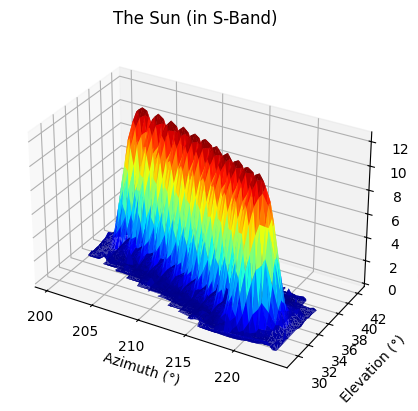

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title("The Sun (in S-Band)")
ax.set_ylabel("Elevation (°)")
ax.set_xlabel("Azimuth (°)")
ax.set_zlabel("Relative Power (dB)")

for az_meas, el_meas, pwrs in zip(az_meas_list, el_meas_list, pwrs_list):
    ax.plot_trisurf(az_meas, el_meas, pwrs-np.min(pwrs), antialiased=True, cmap='jet')
    
ax.set_aspect("equalxy")

In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

In [5]:
cmap = cm.jet
my_cmap = cmap(np.arange(cmap.N))
alph = np.linspace(0, 1, cmap.N)
alph[alph < 0.2] = 0
my_cmap[:,-1] = alph
my_cmap = ListedColormap(my_cmap)

In [6]:
dish = ephem.Observer()
dish.lon = '-105.251825'
dish.lat = '40.010886'
dish.elevation = 1605 # Meters

res = 0.1

xmin = np.min(az_meas_list)
xmax = np.max(az_meas_list)
ymin = np.min(el_meas_list)
ymax = np.max(el_meas_list)

az_grid = np.arange(xmin, xmax, res)
el_grid = np.arange(ymin, ymax, res)

new_pwrs_list = []
pwr_min = np.min(pwrs_list)

sun_meas_az = []
sun_meas_el = []
sun_az = []
sun_el = []

for az_meas, el_meas, pwrs, times in zip(az_meas_list, el_meas_list, pwrs_list, times_list):

    linear_pwrs = 10**(pwrs/10)

    sun_time = times[np.argmax(pwrs)]
    sun_meas_az.append(np.average(az_meas, weights=linear_pwrs))
    sun_meas_el.append(np.average(el_meas, weights=linear_pwrs))

    dt64 = np.datetime64(sun_time)
    ts = (dt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    sun_time = datetime.utcfromtimestamp(ts)

    sun = ephem.Sun()
    dish.date = sun_time
    sun.compute(dish)

    sun_az.append(np.degrees(sun.az))
    sun_el.append(np.degrees(sun.alt))

    new_pwrs_list.append(
        griddata(
            np.vstack((az_meas, el_meas)).T,
            pwrs - pwr_min,
            (az_grid[:,np.newaxis], el_grid[np.newaxis]),
            method='linear',
            fill_value=0
        ))

sun_az = np.array(sun_az)
sun_el = np.array(sun_el)
sun_meas_az = np.array(sun_meas_az)
sun_meas_el = np.array(sun_meas_el)

C:\Users\halot\AppData\Local\Temp\ipykernel_25140\972175121.py:33: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  ts = (dt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


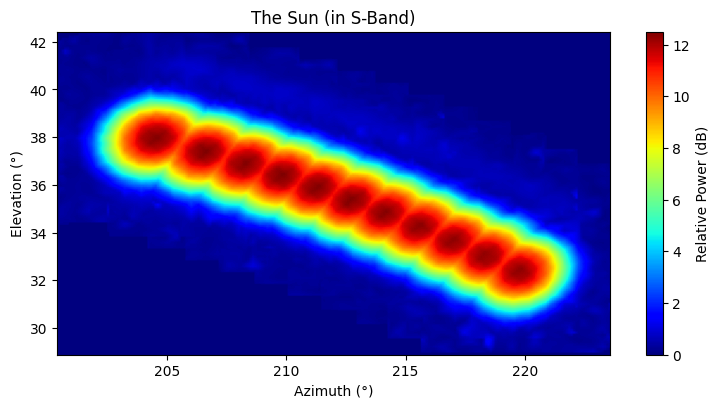

In [11]:
plt.figure(figsize=(8, 4))
plt.title("The Sun (in S-Band)")
plt.ylabel("Elevation (°)")
plt.xlabel("Azimuth (°)")

plt.imshow(
    np.nanmax(new_pwrs_list, axis=0).T,
    #new_pwrs_list[3].T,
    extent=[az_grid[0], az_grid[-1], el_grid[-1], el_grid[0]],
    cmap='jet')

plt.ylim((ymin, ymax))
plt.colorbar(label="Relative Power (dB)")

plt.tight_layout()

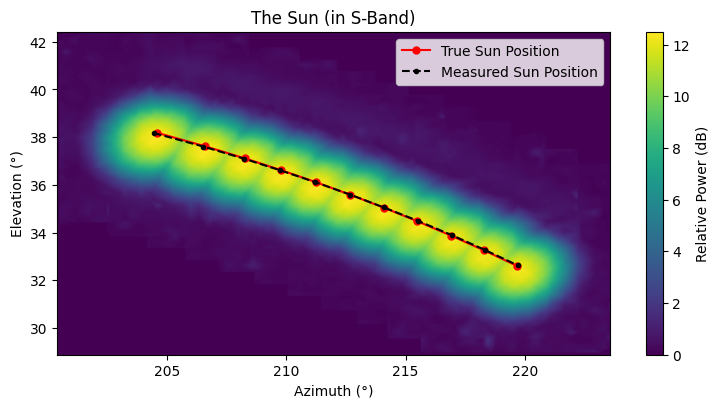

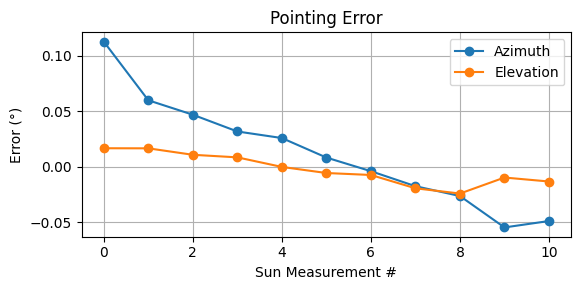

In [12]:
plt.figure(figsize=(8, 4))
plt.title("The Sun (in S-Band)")
plt.ylabel("Elevation (°)")
plt.xlabel("Azimuth (°)")

plt.imshow(
    np.nanmax(new_pwrs_list, axis=0).T,
    #new_pwrs_list[3].T,
    extent=[az_grid[0], az_grid[-1], el_grid[-1], el_grid[0]],
    cmap='viridis')

plt.plot(sun_az, sun_el, 'o-', color='red', label="True Sun Position", markersize=5)
plt.plot(sun_meas_az, sun_meas_el, 'o--', color='black', label="Measured Sun Position", markersize=3)

plt.ylim((ymin, ymax))
plt.colorbar(label="Relative Power (dB)")
plt.legend()
plt.tight_layout()

plt.figure(figsize=(6, 3))
plt.title("Pointing Error")
plt.ylabel("Error (°)")
plt.xlabel("Sun Measurement #")
plt.plot(sun_az-sun_meas_az, 'o-', label="Azimuth")
plt.plot(sun_el-sun_meas_el, 'o-', label="Elevation")
plt.grid()
plt.legend()

plt.tight_layout()